In [856]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot


sns.set()


In [857]:
dick = pd.read_pickle('country_data.pkl')

In [858]:
US = pd.read_pickle('us_state_dict.pkl')
ny = US['New York']
ny = ny[['confirmed','deceased','recovered','inc','factor','dead_inc','dead_factor']]
dick['New York'] = ny

In [859]:
country_name = 'US'

country = dick[country_name]

country

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2020-01-24,2,NaN,NaN,0,NaN,NaN,0.000000,NaN,NaN
2020-01-25,2,1.000000,0.0,0,NaN,0.0,0.000000,NaN,NaN
2020-01-26,5,2.500000,3.0,0,NaN,0.0,0.000000,NaN,NaN
2020-01-27,5,1.000000,0.0,0,NaN,0.0,0.000000,NaN,NaN
2020-01-28,5,1.000000,0.0,0,NaN,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-04-12,555313,1.054934,28917.0,22019,1.076092,1557.0,3.965151,25.219719,1.020057
2020-04-13,580619,1.045571,25306.0,23528,1.068532,1509.0,4.052227,24.677788,1.021960
2020-04-14,607670,1.046590,27051.0,25831,1.097883,2303.0,4.250827,23.524835,1.049010
2020-04-15,636350,1.047197,28680.0,28325,1.096551,2494.0,4.451167,22.466019,1.047130


In [860]:
def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})



In [861]:
country_posterior = pd.read_pickle('violin_daily_result_{}.pkl'.format(country_name.replace(' ','_')))
# r_post = growth factor confirmed, f_post = true mortality rate
country_posterior.describe()

,r_post,f_post,prediction_post
count,35000.000000,35000.000000,35000.000000
mean,1.244233,0.003174,4.822149
std,0.281672,0.000690,0.028567
min,0.677818,0.001534,4.708591
25%,1.058603,0.002724,4.802745
50%,1.216218,0.003095,4.822242
75%,1.382221,0.003556,4.841471
max,2.461054,0.005562,4.934394


In [862]:
C = country['confirmed'][-1]

nr_samples = 1000

rows = np.random.choice(country_posterior.index,replace=True,size=nr_samples)
post_samples = country_posterior.loc[rows]


In [863]:
X = np.linspace(0,len(country),nr_samples)
fwd_look = 40

forecast = np.zeros((fwd_look,nr_samples))

for fwd in range(fwd_look):
    sample_dead = np.array(
       [pm.rpoisson(C * post_samples.r_post.iloc[i] * post_samples.f_post.iloc[i]) for i in range(len(X))])
    
    forecast[fwd] = sample_dead

    # logistic function for daily growth of C : general form for growth factor : (1 - ( N  / population ) ) * N
    C  = C * country['factor'][-1] * (1 - (C / (country_populations.loc[country_name,'population'] \
                                                * country_posterior.f_post.mean() * 5)))
    

forecast_df = pd.DataFrame(forecast).T
forecast_df.index.name = 'sample'
forecast_df.columns.name = 'day'



day         0       1       2       3       4       5       6       7   \
sample                                                                   
0       2490.0  2297.0  2188.0  2031.0  1874.0  1751.0  1735.0  1590.0   
1       2595.0  2269.0  2227.0  2044.0  1966.0  1872.0  1678.0  1644.0   
2       2536.0  2278.0  2164.0  1960.0  1874.0  1804.0  1665.0  1632.0   
3       2399.0  2381.0  2100.0  2067.0  1923.0  1812.0  1687.0  1707.0   
4       2524.0  2301.0  2150.0  1956.0  1903.0  1803.0  1678.0  1617.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
995     2479.0  2322.0  2134.0  2040.0  1842.0  1741.0  1683.0  1698.0   
996     2447.0  2285.0  2068.0  2073.0  1896.0  1772.0  1775.0  1605.0   
997     2497.0  2262.0  2114.0  2141.0  1879.0  1817.0  1722.0  1657.0   
998     2630.0  2363.0  2129.0  2008.0  1912.0  1762.0  1779.0  1602.0   
999     2431.0  2280.0  2150.0  2033.0  1926.0  1739.0  1688.0  1630.0   

day         8       9   ...      30  

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
sample,,,,,,,,,,,,,,,,,,,,,
0,2490.0,2297.0,2188.0,2031.0,1874.0,1751.0,1735.0,1590.0,1598.0,1590.0,...,1041.0,1079.0,1055.0,1105.0,1028.0,1079.0,1037.0,1037.0,1052.0,1021.0
1,2595.0,2269.0,2227.0,2044.0,1966.0,1872.0,1678.0,1644.0,1580.0,1587.0,...,1090.0,1095.0,1064.0,1070.0,1107.0,1061.0,1052.0,1002.0,969.0,1009.0
2,2536.0,2278.0,2164.0,1960.0,1874.0,1804.0,1665.0,1632.0,1492.0,1515.0,...,1068.0,1076.0,1042.0,1077.0,1051.0,1019.0,1014.0,1035.0,986.0,1059.0
3,2399.0,2381.0,2100.0,2067.0,1923.0,1812.0,1687.0,1707.0,1622.0,1469.0,...,1109.0,1069.0,1053.0,1082.0,1043.0,1103.0,999.0,1012.0,1006.0,992.0
4,2524.0,2301.0,2150.0,1956.0,1903.0,1803.0,1678.0,1617.0,1572.0,1548.0,...,1123.0,1055.0,1062.0,1031.0,1077.0,1100.0,1009.0,1049.0,992.0,1054.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2479.0,2322.0,2134.0,2040.0,1842.0,1741.0,1683.0,1698.0,1628.0,1447.0,...,1020.0,1058.0,1104.0,994.0,1054.0,1035.0,1017.0,1025.0,1044.0,963.0
996,2447.0,2285.0,2068.0,2073.0,1896.0,1772.0,1775.0,1605.0,1605.0,1483.0,...,1017.0,1110.0,1074.0,1024.0,1007.0,1083.0,1003.0,1004.0,1022.0,1050.0
997,2497.0,2262.0,2114.0,2141.0,1879.0,1817.0,1722.0,1657.0,1554.0,1475.0,...,1064.0,1062.0,1046.0,1090.0,970.0,1048.0,1023.0,1011.0,1036.0,971.0


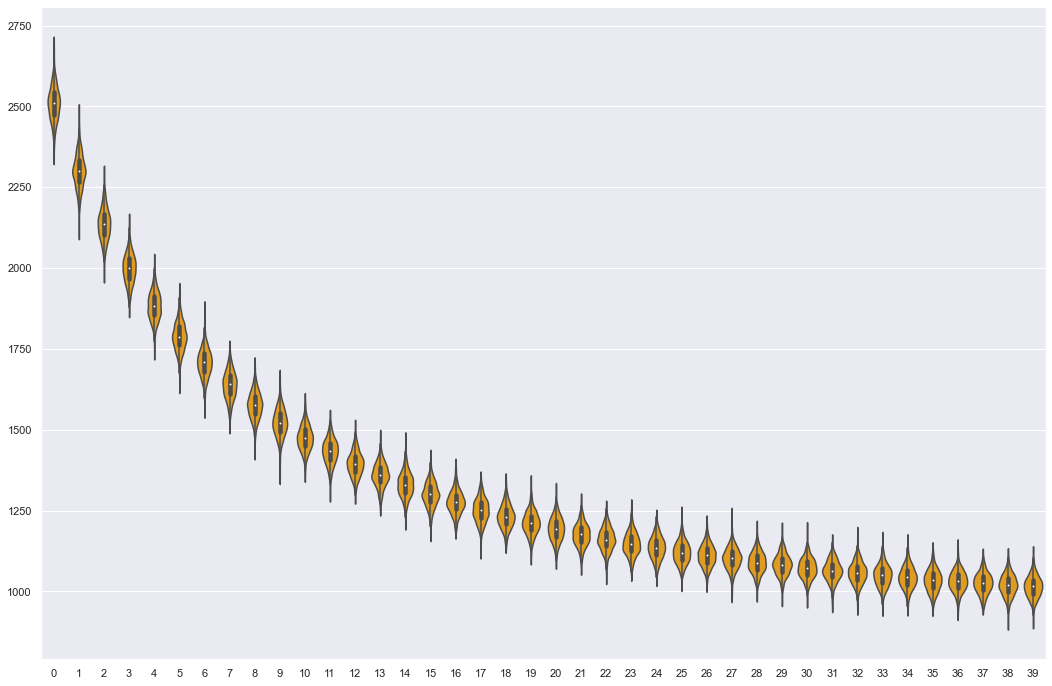

In [864]:
plt.figure(figsize=(18,12))

means = forecast_df.mean(axis=0)
current = country.iloc[-1,5]

over_current = means > current
forecast_df.drop(forecast_df.columns[over_current],axis=1,inplace=True)

print (forecast_df)
forecast_df.columns = range(0,len(forecast_df.columns) )

means = forecast_df.mean(axis=0)
CI_89 = np.percentile(forecast_df,[5.5,94.5],axis=0)
CI_89_low = CI_89[0,:]
CI_89_high = CI_89[1,:]


sns.violinplot(data=forecast_df,palette=['orange'],inner='box')

print (CI_89_low)
print (CI_89_high)

#start_day = country.index[0].date()
start_day = pd.datetime.today().date()


forecast_df.to_pickle('dead_forecast_{}_starting_{}.pkl'.format(country_name.replace(' ','_'),start_day))
forecast_df

<ErrorbarContainer object of 3 artists>

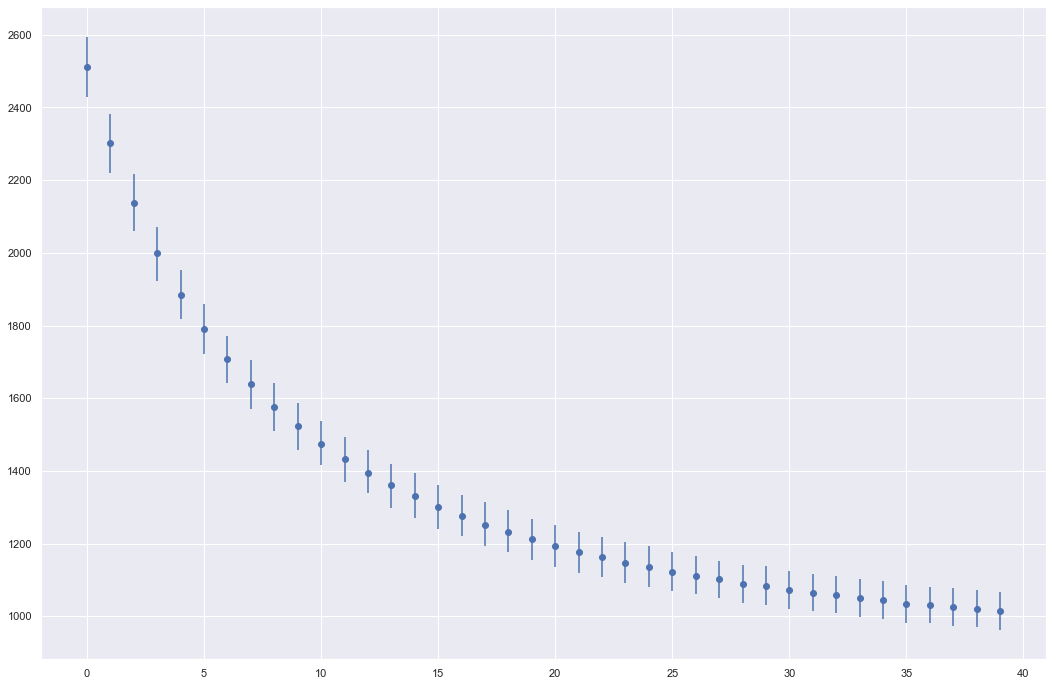

In [865]:
plt.figure(figsize=(18,12))
plt.errorbar(range(len(forecast_df.columns)),means,np.array((np.abs(means - CI_89_low),np.abs(means - CI_89_high))),fmt='o')